## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Datasets

In [3]:
natality_df = pd.read_csv("datasets/natality/db.csv")

natality_df = natality_df[[
    "SPECIFICATION: Specification",  # Location
    "VARIABLE: Variable",  # Type
    "TIME_PERIOD: Time period",  # Year
    "OBS_VALUE",  # Value
]]

# Rename columns to make it easier to work with
natality_df.columns = ["location", "type", "year", "value"]

type_to_short_name = {
    "A01: Live births by municipality of residence": "Live births",
    "A02: Deaths by municipality of residence": "Deaths",
    "A03: Natural balance by municipality of residence": "Natural balance",
}

natality_df["type"] = natality_df["type"].map(type_to_short_name)
natality_df["value"] = natality_df["value"].fillna(0)

In [4]:
migration_df = pd.read_csv("datasets/migration/db.csv")

migration_df = migration_df[[
    "SPECIFICATION: Specification",  # Location
    "POP_MOVEMENT: Population Movement",  # Type
    "TIME_PERIOD: Time period",  # Year
    "OBS_VALUE",  # Value
]]

# Rename columns to make it easier to work with
migration_df.columns = ["location", "type", "year", "value"]
migration_df["value"] = migration_df["value"].fillna(0)


In [5]:
prices_df = pd.read_csv("datasets/house_prices/csv/prices.csv")
totals_df = pd.read_csv("datasets/house_prices/csv/totals.csv")

# There's 1 row with a NaN value in the prices_df dataframe
prices_df = prices_df.fillna("*")

# Plot the total houses sold per year
totals_df["Total Houses Sold"] = totals_df["Total Finished Houses Sold"] + totals_df["Total Unfinished Houses Sold"]
totals_df["Total Average Price"] = (totals_df["National Average Price per m^2 of Finished Houses"] +
                                    totals_df["National Average Price per m^2 of Unfinished Houses"]) / 2

convert_range = lambda x: x.replace(" ", "").replace("€", "").split("-")

totals_df["National Average Range of Price per m^2 of Finished Houses"] = totals_df[
    "National Average Range of Price per m^2 of Finished Houses"].map(convert_range)
totals_df["National Average Range of Price per m^2 of Unfinished Houses"] = totals_df[
    "National Average Range of Price per m^2 of Unfinished Houses"].map(convert_range)

for i, row in enumerate(prices_df["m^2 price range"]):
    prices_df.at[i, "m^2 price range"] = convert_range(row) if row != "*" else "*"

for i, row in enumerate(prices_df["Unfinished Houses m^2 price range"]):
    prices_df.at[i, "Unfinished Houses m^2 price range"] = convert_range(row) if row != "*" else "*"


Joining the migration data with the natural movement data.

In [6]:
# We want to join the dataframes on the location and year columns
population_df = migration_df.copy()
# Drop all rows with years that are smaller than 1990
population_df = population_df[population_df["year"] >= 1990]

for i, row in natality_df.iterrows():
    if row["type"] == "Live births":
        # Add to the M001: Arrivals column
        population_df.loc[(population_df["location"] == row["location"]) & (population_df["year"] == row["year"])
                          & (population_df["type"] == "M001: Arrivals"), "value"] += row["value"]
    elif row["type"] == "Deaths":
        # Add to the M002: Departures column
        population_df.loc[(population_df["location"] == row["location"]) & (population_df["year"] == row["year"])
                          & (population_df["type"] == "M002: Departures"), "value"] += row["value"]
    elif row["type"] == "Natural balance":
        # Add to the M003: Net migration column
        population_df.loc[(population_df["location"] == row["location"]) & (population_df["year"] == row["year"])
                          & (population_df["type"] == "M003: Net migration"), "value"] += row["value"]

population_df["type"] = population_df["type"].map({
    "M001: Arrivals": "Increase",
    "M002: Departures": "Decrease",
    "M003: Net migration": "Balance"
})


In [7]:
population_df

,location,type,year,value
0,CM10008: Mondercange,Increase,1990,434.0
1,CM10008: Mondercange,Increase,1991,552.0
2,CM10008: Mondercange,Increase,1992,618.0
3,CM10008: Mondercange,Increase,1993,560.0
4,CM10008: Mondercange,Increase,1994,528.0
...,...,...,...,...
11380,CM08003: Lenningen,Balance,2018,18.0
11381,CM08003: Lenningen,Balance,2019,76.0
11382,CM08003: Lenningen,Balance,2020,56.0
11383,CM08003: Lenningen,Balance,2021,-21.0


In [8]:
totals_df

,Year,Total Finished Houses Sold,National Average Price per m^2 of Finished Houses,National Average Range of Price per m^2 of Finished Houses,Total Unfinished Houses Sold,National Average Price per m^2 of Unfinished Houses,National Average Range of Price per m^2 of Unfinished Houses,Total Houses Sold,Total Average Price
0,2007,2207.0,3507.182,"[2327, 4731]",1307.0,3945.805,"[2733, 5478]",3514.0,3726.4935
1,2008,2026.0,3578.830,"[2273, 4978]",1254.0,4203.922,"[2982, 5611]",3280.0,3891.3760
2,2009,2182.0,3488.124,"[2301, 4852]",979.0,4264.941,"[2894, 6203]",3161.0,3876.5325
3,2010,2302.0,3663.585,"[2438, 5142]",1407.0,4480.081,"[3155, 6374]",3709.0,4071.8330
4,2011,2562.0,3858.319,"[2533, 5487]",1621.0,4633.802,"[3232, 6448]",4183.0,4246.0605
5,2012,2400.0,3998.736,"[2543, 5933]",1545.0,4845.979,"[3221, 6853]",3945.0,4422.3575
6,2013,2372.0,4160.000,"[2624, 6176]",1497.0,5191.000,"[3382, 7502]",3869.0,4675.5000
7,2014,2896.0,4323.188,"[2754, 6487]",1832.0,5283.350,"[3444, 7897]",4728.0,4803.2690
8,2015,2802.0,4470.578,"[2782, 6803]",1740.0,5589.387,"[3683, 7772]",4542.0,5029.9825
9,2016,3069.0,4795.104,"[2952, 7641]",1812.0,6050.853,"[3852, 8995]",4881.0,5422.9785


## Analysis

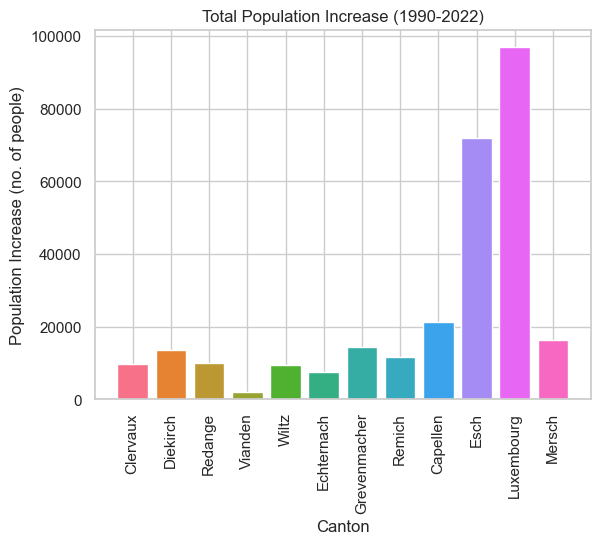

[('Clervaux', 9772.0), ('Diekirch', 13593.0), ('Redange', 10074.0), ('Vianden', 2047.0), ('Wiltz', 9433.0), ('Echternach', 7616.0), ('Grevenmacher', 14508.0), ('Remich', 11624.0), ('Capellen', 21328.0), ('Esch', 71820.0), ('Luxembourg', 96904.0), ('Mersch', 16189.0)]


In [151]:
cantons = population_df[population_df["location"].str.startswith("CT")]
data = []
# Plot the net balance of population summed over the years in a bar chart for each canton
for canton in cantons["location"].unique():
    canton_balance = cantons[(cantons["location"] == canton) & (cantons["type"] == "Balance")].sum()["value"]
    data += [(canton, canton_balance)]

data = sorted(data, key=lambda x: x[0])
# Remove the 1st 2 words from the canton name
cs = [c.split(" ") for c, _ in data]
cs = [" ".join(c[2:]) for c in cs]
data = [(c, b) for c, b in zip(cs, [b for _, b in data])]

fig, ax = plt.subplots()
# Aplly a nice color palette
plt.bar([canton for canton, _ in data], [balance for _, balance in data], color=sns.color_palette("husl", len(data)))
plt.xticks(rotation=90)

plt.xlabel("Canton")
plt.ylabel("Population Increase (no. of people)")
plt.title("Total Population Increase (1990-2022)")
plt.show()

print(data)

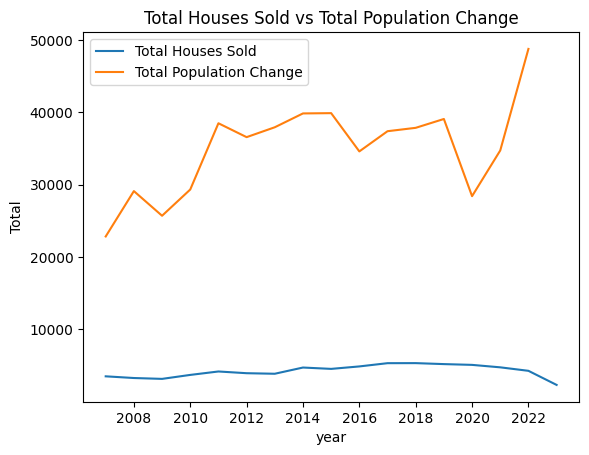

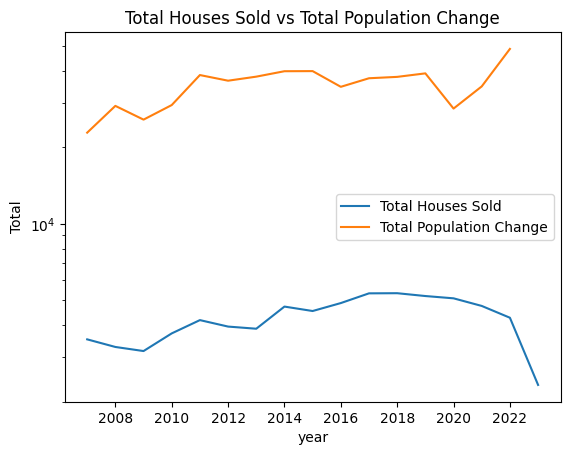

In [9]:
# Plot the total houses sold per year and the total population change per year from 2007 onwards
fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Houses Sold", ax=ax, label="Total Houses Sold")
# We only want to plot the population change from 2007 onwards since that's when the house prices data starts
population_df_ = population_df[population_df["year"] >= 2007].copy()
# Group by year and get only the values of type "Balance"
population_df_ = population_df_[population_df_["type"] == "Balance"]
population_df_ = population_df_.groupby("year").sum()
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total")
plt.title("Total Houses Sold vs Total Population Change")
plt.show()

# Now with a log scale
fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Houses Sold", ax=ax, label="Total Houses Sold")
population_df_ = population_df[population_df["year"] >= 2007].copy()
population_df_ = population_df_[population_df_["type"] == "Balance"]
population_df_ = population_df_.groupby("year").sum()
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total")
plt.yscale("log")
plt.title("Total Houses Sold vs Total Population Change")
plt.show()


We can see that despite the huge population increase, the number of sold houses hasn't changed much.

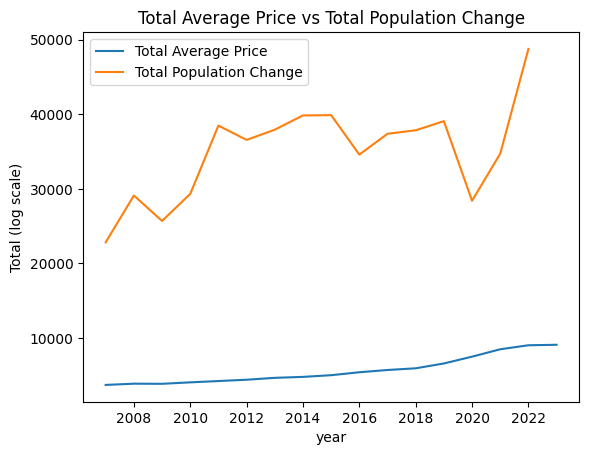

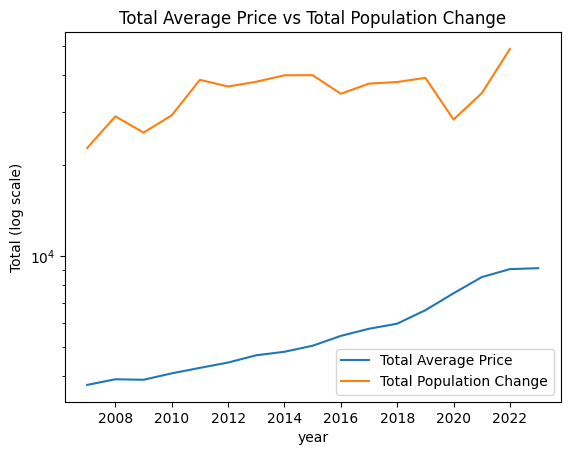

In [10]:
# Plot the house prices per year and the total population change per year from 2007 onwards
fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Average Price", ax=ax, label="Total Average Price")
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total (log scale)")
plt.title("Total Average Price vs Total Population Change")
# Change the y-axis to a logarithmic scale
plt.show()

fig, ax = plt.subplots()
totals_df.plot(x="Year", y="Total Average Price", ax=ax, label="Total Average Price")
population_df_.plot(y="value", ax=ax, label="Total Population Change")
plt.ylabel("Total (log scale)")
plt.title("Total Average Price vs Total Population Change")
# Change the y-axis to a logarithmic scale
plt.yscale("log")
plt.show()


It's easier to see the changes with the log scale.

array([[22836.],
       [29103.],
       [25698.],
       [29322.],
       [38475.],
       [36558.],
       [37923.],
       [39834.],
       [39873.],
       [34587.],
       [37377.],
       [37845.],
       [39066.],
       [28404.],
       [34717.],
       [48746.]])

array([[3726.4935],
       [3891.376 ],
       [3876.5325],
       [4071.833 ],
       [4246.0605],
       [4422.3575],
       [4675.5   ],
       [4803.269 ],
       [5029.9825],
       [5422.9785],
       [5727.0435],
       [5953.906 ],
       [6601.206 ],
       [7513.894 ],
       [8503.466 ],
       [9040.1925]])

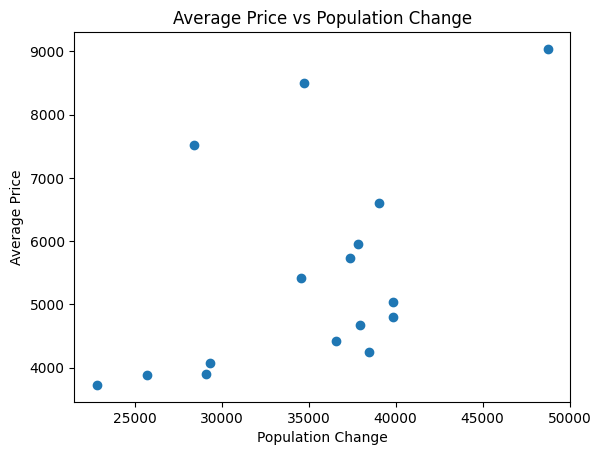

In [37]:
# Plot the house prices per year vs the total population change per year from 2007 onwards
X = population_df_.loc[:, "value"].values.reshape(-1, 1)
y = totals_df.loc[(totals_df["Year"] >= 2007) & (totals_df["Year"] < 2023), "Total Average Price"].values.reshape(-1, 1)

display(X)
display(y)

fig, ax = plt.subplots()
plt.scatter(X, y)
plt.xlabel("Population Change")
plt.ylabel("Average Price")
plt.title("Average Price vs Population Change")
plt.show()

16


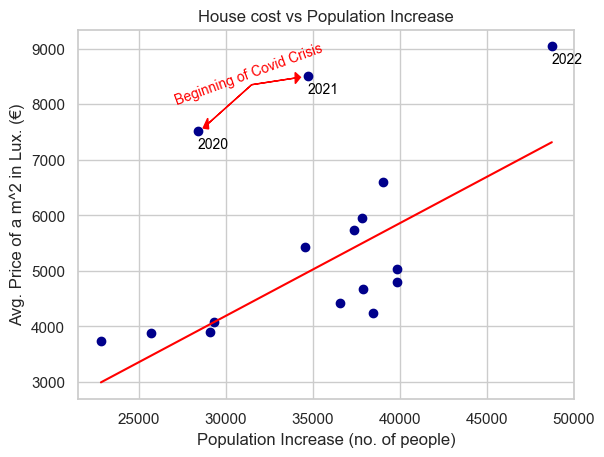

MSE: 714907.9687815981


In [246]:
import matplotlib.patches as patches
# Perform a regression analysis to see if there's a correlation between the average price and the population change
from sklearn.linear_model import LinearRegression

reg_X = X.copy()
reg_y = y.copy()

# Remove the 2 penultimate elements from the arrays since they are outliers (the last element should stay)
reg_X = reg_X[:-3]
# Add the last element of X to reg_X
reg_X = np.append(reg_X, X[-1]).reshape(-1, 1)
reg_y = reg_y[:-3]
# Add the last element of y to reg_y
reg_y = np.append(reg_y, y[-1]).reshape(-1, 1)

# Sort the X values from smallest to largest and the y values accordingly
sorted_indices = np.argsort(reg_X.flatten())
reg_X = reg_X[sorted_indices]
reg_y = reg_y[sorted_indices]

reg = LinearRegression().fit(reg_X, reg_y)

print(len(X))
outlier_indices = [13, 14, 15]

fig, ax = plt.subplots()
# Apply a nice color palette
plt.scatter(X, y, color="darkblue")

# Highlight outliers
# average of x and y values
for i, idx in enumerate(outlier_indices):
    x_outlier = X[idx]
    y_outlier = y[idx]
    plt.annotate(f"{2020+i}", xy=(x_outlier, y_outlier - 300), fontsize=10, color="black")

plt.annotate("Beginning of Covid Crisis", rotation=20, xy=(25000 + 2000, 8000), fontsize=10, color="red")
# Add an arrow pointing to the outlier
plt.arrow(25000 + 6500, 8000 + 350, 2500, +120, head_width=200, head_length=300, fc='red', ec='red')
plt.arrow(25000 + 6500, 8000 + 350, -2500, -700, head_width=200, head_length=300, fc='red', ec='red')

plt.plot(reg_X, reg.predict(reg_X), color="red")
plt.xlabel("Population Increase (no. of people)")
plt.ylabel("Avg. Price of a m^2 in Lux. (€)")
plt.title("House cost vs Population Increase")
# plt.savefig("house_cost_vs_population_increase.svg", format="svg")
plt.show()

# MSE of the regression
mse = np.mean((reg.predict(reg_X) - reg_y)**2)
print(f"MSE: {mse}")

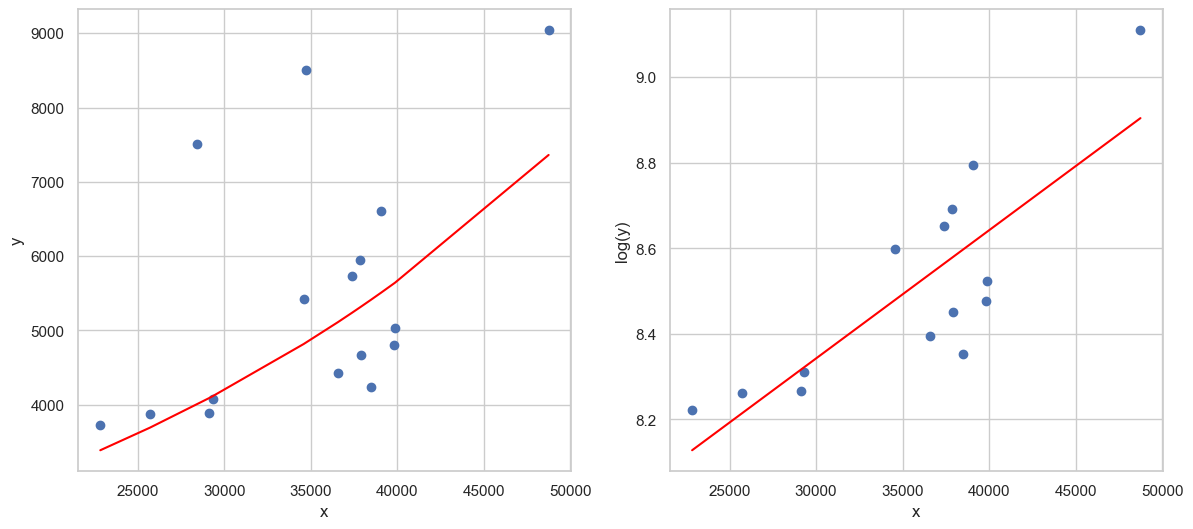

MSE: 2817687.40210013
MSE: 0.09380252182330973


In [107]:
log_y = np.log(reg_y)
linear_coefficients = np.polyfit(reg_X.flatten(), log_y.flatten(), 1)
b = linear_coefficients[0]
a = linear_coefficients[1]
a = np.exp(a)

log_y_fit = np.polyval(linear_coefficients, reg_X.flatten())
y_fit = np.exp(log_y_fit)

# Plot the original data and the fitted exponential curve
plt.figure(figsize=(14, 6))

# Original data and fitted exponential curve
plt.subplot(1, 2, 1)
plt.scatter(X, y, label='Original Data')
plt.plot(reg_X, y_fit, color='red', label='Fitted Exponential Curve')
plt.xlabel('x')
plt.ylabel('y')

# Log-transformed data and linear fit
plt.subplot(1, 2, 2)
plt.scatter(reg_X, np.log(reg_y), label='Log-Transformed Data')
plt.plot(reg_X, log_y_fit, color='red', label='Linear Fit')
plt.xlabel('x')
plt.ylabel('log(y)')

plt.show()

# MSE of the exponential fit
mse = np.mean((reg_y - y_fit) ** 2)
print(f"MSE: {mse}")
# MSE of the linear fit
mse = np.mean((np.log(reg_y) - log_y_fit) ** 2)
print(f"MSE: {mse}")